# Flip-Flop Index

The Flip-Flop Index quantifies the stability of a forecast without penalising a trend toward more accurate values at shorter lead times. The Flip-Flop Index has the same units as the forecast, with smaller values indicating greater stability (fewer "flip-flops"). The Flip-Flop Index cannot be used to verify a forecast. Indeed, it does not use the verifying observation in its calculation. However, it describes an (arguably important) characteristic of a sequence of forecasts for an event. 

Read about the Flip-Flop Index at:  

- Griffiths D. et al. (2019). Flip-Flop Index: Quantifying Revision Stability for Fixed-Event Forecasts, 
*Meteorological Applications*, 26, 30-35. [https://doi.org/10.1002/met.1732](https://doi.org/10.1002/met.1732)   
- Griffiths D. et al. (2021). Circular Flip-Flop Index: quantifying revision stability of forecasts of direction, *Journal of Southern Hemisphere Earth Systems Science*, 71, 266–271. [https://doi.org/10.1071/ES21010](https://doi.org/10.1071/ES21010)

The two functions demonstrated here are `flip_flop_index` which calculates the index for individual forecast revision series, and `flip_flop_index_proportion_exceeding` which summarises the Flip-Flop Index values over many forecast revision series by reporting the frequency with which it exceeded values of interest.

In [ ]:
from scipy.stats import skewnorm
import numpy as np
import xarray as xr
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt

from scores.continuous import mse
from scores.continuous import flip_flop_index_proportion_exceeding, flip_flop_index

In [2]:
# help(flip_flop_index)  # Uncomment this to see the help message

In [3]:
# help(flip_flop_index_proportion_exceeding)  # Uncomment this to see the help message

In [4]:
# Create two synthetic forecast revision series.
# These might represent a forecast of 28 degrees a week in advance of the event, updated daily with a forecast of 21 degrees the day before the event.
# Inspection (and the graph below) shows that the unstable_fcst jumps around while the stable_fcst has a cooler trend each day.
unstable_fcst = xr.DataArray(data=[21., 23, 18, 20, 26, 25, 28], dims="lead_day", coords={"lead_day": np.arange(1, 8)})
stable_fcst = xr.DataArray(data=[21., 23, 23, 24, 25, 26, 28], dims="lead_day", coords={"lead_day": np.arange(1, 8)})

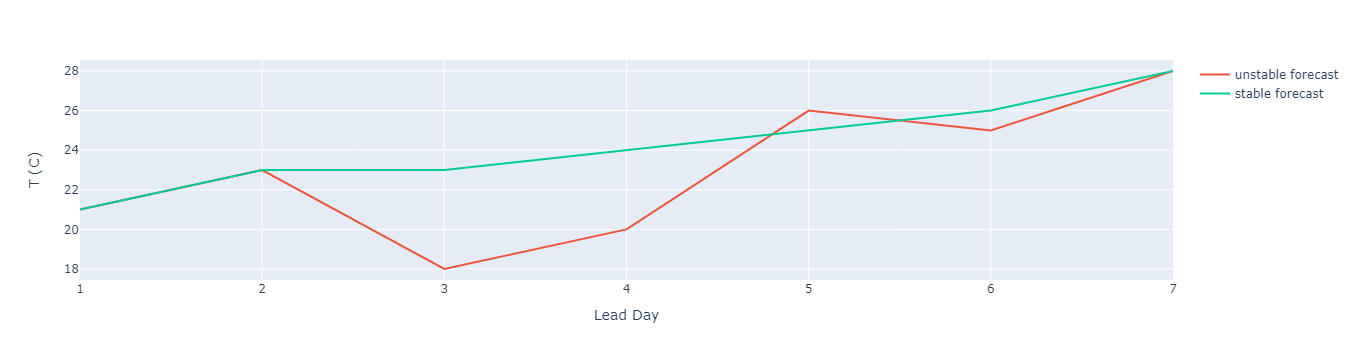

In [ ]:
fig = px.scatter()
fig.add_scatter(x=unstable_fcst['lead_day'], y=unstable_fcst, mode="lines", name="unstable forecast")
fig.add_scatter(x=unstable_fcst['lead_day'], y=stable_fcst, mode="lines", name="stable forecast").update_layout(xaxis_title="Lead Day", yaxis_title="T (C)")
fig.show()

In [6]:
# The Flip-Flop Index of 1.8 for the noisy forecast quantifies the lack of stability.
flip_flop_index(unstable_fcst, "lead_day")

<xarray.DataArray ()>
array(1.8)
Attributes:
    sampling_dim:  lead_day

In [7]:
# The Flip-Flop Index for the stable forecast is 0, reflecting no flip-flopping.
flip_flop_index(stable_fcst, "lead_day")

<xarray.DataArray ()>
array(0.)
Attributes:
    sampling_dim:  lead_day

In [8]:
# Working with real data requires several forecast issuances, which is a very large amount of gridded data. 
# We choose to work with synthetic data to keep this example tightly focused.
# We will start with synthetic observations and add perturbations to create synthetic forecasts.

# Create synthetic temperature observations for 100 days and 100 locations (so, 10,000 observations)
# The values of the observations are between 0 and 40.
obs = 40 * np.random.random((100, 100))
obs = xr.DataArray(
    data=obs, 
    dims=["time", "location number"],
    coords={"time": pd.date_range("2023-01-01", "2023-04-10"), "location number": np.arange(0, 100)}
)

# Create forecasts for 7 lead days
# Each observation has 7 forecast values, issued between 1 and 7 days in advance.
# We create two such forecasts, initially matching the observations, then adding some noise to simulate a forecast
fcst1 = xr.DataArray(data=[1]*7, dims="lead_day", coords={"lead_day": np.arange(1, 8)})
fcst1 = fcst1 * obs
fcst2 = fcst1.copy()

# fcst1 is 70,000 forecasts, with 10,000 forecast revision sequences.
# Each forecast revision sequence is predicting one specific obeservation.
# Similarly for fcst2.

# Create some noise to add to the forecasts to make them interesting and more realistic.
# The noise increases with lead-day reflecting less accurate forecasts at longer lead days.
noise = skewnorm.rvs(4, size=(1, 100, 100))
noise_for_fcst1 = noise.copy()
noise_for_fcst2 = noise.copy()
for lead_day in np.arange(1, 7):
    next_lead_day_noise = (1+lead_day/7)*skewnorm.rvs(4, size=(1, 100, 100))
    noise_for_fcst1 = np.concatenate((noise_for_fcst1, next_lead_day_noise))
    if lead_day % 2 == 0:
        noise_for_fcst2 = np.concatenate((noise_for_fcst2, -1*next_lead_day_noise))
    else:
        noise_for_fcst2 = np.concatenate((noise_for_fcst2, next_lead_day_noise))

# Add the noise to get the final forecasts.
fcst1 += noise_for_fcst1
fcst2 += noise_for_fcst2

In [9]:
# Calculate the Mean Square Error to confirm that the forecasts are less accurate at longer lead days
mse(fcst1, obs, preserve_dims=["lead_day"]).round(2)

<xarray.DataArray (lead_day: 7)>
array([0.99, 1.32, 1.66, 2.04, 2.48, 2.88, 3.42])
Coordinates:
  * lead_day  (lead_day) int64 1 2 3 4 5 6 7

In [10]:
# By design, fcst2 has the same absolute errors as fcst1, and hence the same mean square errors.
mse(fcst2, obs, preserve_dims=["lead_day"]).round(2)

<xarray.DataArray (lead_day: 7)>
array([0.99, 1.32, 1.66, 2.04, 2.48, 2.88, 3.42])
Coordinates:
  * lead_day  (lead_day) int64 1 2 3 4 5 6 7

In [11]:
# We can use the flip_flop_index to calculate the Flip-Flop Index for the revision sequence for each date and location.
flip_flop_index(fcst1, "lead_day").round(2)

<xarray.DataArray (time: 100, location number: 100)>
array([[1.09, 0.29, 0.15, ..., 0.25, 1.27, 0.59],
       [0.63, 0.44, 0.96, ..., 1.35, 1.39, 0.23],
       [0.97, 0.47, 0.19, ..., 1.39, 0.91, 0.97],
       ...,
       [0.62, 0.57, 1.09, ..., 0.97, 1.52, 0.33],
       [0.84, 0.58, 0.53, ..., 0.25, 0.33, 0.63],
       [0.71, 1.37, 1.13, ..., 0.64, 0.58, 0.62]])
Coordinates:
  * time             (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-04-10
  * location number  (location number) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Attributes:
    sampling_dim:  lead_day

In [12]:
# We expect fcst2 to be less stable (have more flip-flopping) than fcst1.
# Calculating the frequency with with the Flip-Flop Index exceeds 1 confirms that
# the Flip-Flop Index for exceeds 1 only about 20% of the time for fcst1, but well over 80% of the time for fcst2.
# The exact values depend on the random noise generated each time this notebook is run.
print(flip_flop_index_proportion_exceeding(fcst1, "lead_day", [1]).values)
print(flip_flop_index_proportion_exceeding(fcst2, "lead_day", [1]).values)

[0.1854]
[0.848]


Text(0.5, 1.0, 'Lead Days 1-2-3-4-5-6-7')

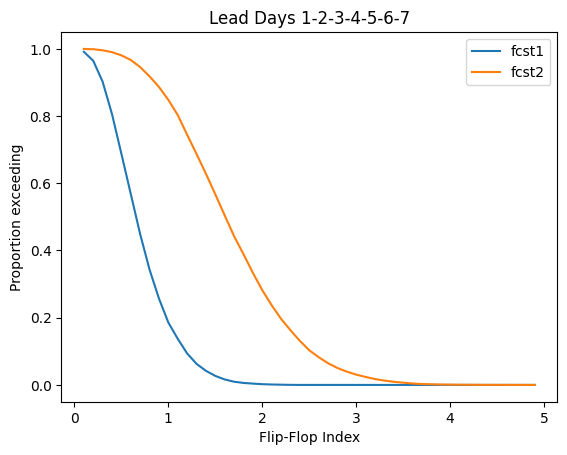

In [13]:
# You can display a graph showing the proportion of times the Flip-Flop exceeds the x-value as is done here.
# We are calculating `flip_flop_index_proportion_exceeding` each of 0.1, 0.2, 0.3 etc.
# The lower line represents the comparative stability fcst1 with the higher line representing the jumpiness of fcst2 as a system.
# Many of the fcst2 revision sequences have a Flip-Flop Index exceeding 2 but barely any of fcst1.
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 5, 0.1)).plot()
flip_flop_index_proportion_exceeding(fcst2, "lead_day", np.arange(0.1, 5, 0.1)).plot()
plt.legend(['fcst1', 'fcst2'])
plt.xlabel("Flip-Flop Index")
plt.ylabel("Proportion exceeding")
plt.title('Lead Days 1-2-3-4-5-6-7')

Text(0.5, 1.0, 'fcst1')

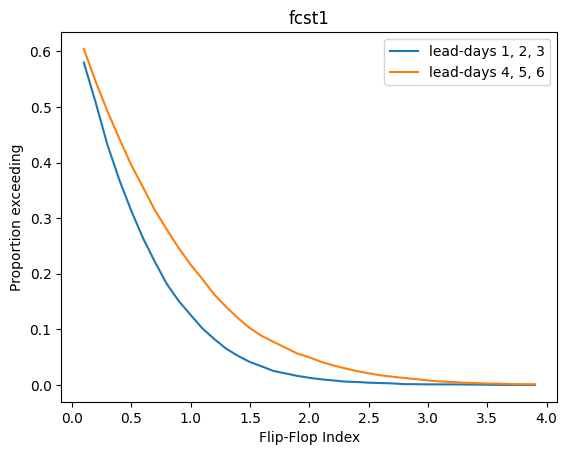

In [14]:
# Considering just fcst1, we can compare the Flip-Flop Index of three forecasts in the revision series.
# We see here that the shorter lead-day forecasts flip-flop slightly less than the longer range forecasts.
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 4, 0.1), days123=[1, 2, 3]).days123.plot()
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 4, 0.1), days456=[4, 5, 6]).days456.plot()
plt.legend(['lead-days 1, 2, 3', 'lead-days 4, 5, 6'])
plt.xlabel("Flip-Flop Index")
plt.ylabel("Proportion exceeding")
plt.title('fcst1')

Next Steps:

- Try `flip_flop_index` on some real data of interest.
- Try on some forecasts of direction using the argument `is_angular=True`
- For `flip_flop_index_proportion_exceeding` try the `reduce_dims` or `preserve_dims` to report data conditioned by something of interest. For example, if your data includes `season` or `forecast zone` you can report exceedence values for those.
- It is not appropriate to consider the Flip-Flop Index from forecast revision sequences of different lengths. Do you agree?